In [1]:
# Setting Up Everything
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

import os
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import clip
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from torch import nn
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader


/bin/bash: line 1: conda: command not found
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7ebp4yen
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7ebp4yen
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


/tmp/ipykernel_4875/2139800475.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Displaying all available models in Clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
# Selecting the Device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the Model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# Printing the model size and parameters
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


2024-02-18 19:40:12.972862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 19:40:12.972944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 19:40:12.996179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 19:40:13.045695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 19:40:13.860033: W tensorflow/compiler/tf2

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
allImagesPathsandTexts = []

# Path to data directory
dataDir = "/home/cshah/workspaces/Deep Learning/DL Project/data/256_ObjectCategories/"

# Loading the Data and saving it in the right format
for file in os.listdir(dataDir):

    dotInFileName = os.path.basename(file).rfind(".")
    if dotInFileName == 0:
        continue
    name = os.path.basename(file)[dotInFileName+1:]
    filePath = os.path.join(dataDir, os.path.basename(file))

    for fileImages in [fileImages for fileImages in os.listdir(filePath) if fileImages.endswith(".jpg")]:
        
        allImagesPathsandTexts.append((os.path.join(filePath, fileImages),name))
        
# Define a custom dataset nad data preprocessing
class imageDataset():
    def __init__(self, imagePathsAndlstTxts):
        # Initialize image paths and corresponding texts

        imagePathList = [pair[0] for pair in imagePathsAndlstTxts]
        txtList = [pair[1] for pair in imagePathsAndlstTxts]
        self.imagePaths = imagePathList
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(txtList)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        imageReturn = preprocess(Image.open(self.imagePaths[idx]))
        title = self.title[idx]
        return imageReturn, title


In [6]:

# Parameters
batch_size = 8

# Splitting into training(80%) and Validation Sets(20%)
trainingDataPer = 30; 
trainDataLen = int(len(allImagesPathsandTexts) * trainingDataPer / 100)
validationDataPer = 5;
validationDataLen = int(len(allImagesPathsandTexts) * validationDataPer / 100)

# Shuffle the dataset
random.shuffle(allImagesPathsandTexts)

# Setting up the dataset
# Training Dataset
trainingDataset = imageDataset(allImagesPathsandTexts[0:trainDataLen][:])
trainDatasetLoader = DataLoader(trainingDataset, batch_size=batch_size, shuffle=True, num_workers=8)

# Validation Dataset
validationDataset = imageDataset(allImagesPathsandTexts[len(allImagesPathsandTexts)-validationDataLen:len(allImagesPathsandTexts)][:])
validationDatasetLoader = DataLoader(validationDataset, batch_size=batch_size, shuffle=False, num_workers=8)


In [7]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

# Check if the device is set to CPU
if device == "cpu":
    model.float()  # Convert the model's parameters to float if using CPU

# Prepare the optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6 ,weight_decay=0.2) 

# Specify the loss function for images
lossImg = nn.CrossEntropyLoss()

# Specify the loss function for text
lossTxt = nn.CrossEntropyLoss()

In [8]:
# Model Evaluation
def evaluateModel(model, dataLoader, device):
    model.eval()
    correctPredictions = 0
    total = 0
    with torch.no_grad():
        for batch in dataLoader:
            features, labels = batch
            
            features = features.to(device)
            labels = labels.to(device)

            # Calculate Logit and prob
            logitsPerImage, logitsPerText = model(features, labels)

            # Ground Truth
            groundTruth = torch.arange(len(features), dtype=torch.long, device=device)

            # Take argmax of logits
            argMaxImages = torch.argmax(logitsPerImage, dim=1);
            argMaxText = torch.argmax(logitsPerText, dim=0);

            # Calculate accuracy
            compareImages = (argMaxImages == groundTruth);
            compareTexts = (argMaxImages == groundTruth);
            correctPredictions += (torch.sum(compareImages).item() + torch.sum(compareTexts).item())/2
                         
            total += labels.size(0)
        
    accuracy = 100 * correctPredictions / total
    return accuracy



In [9]:
# Model Training
trainingLoss = []
whileTrainAcc = []

num_epochs = 100
for epoch in range(num_epochs):
    totalLossValue = 0
    pbar = tqdm(trainDatasetLoader, total=len(trainDatasetLoader))
    for batch in pbar:
        optimizer.zero_grad()
        images,texts = batch 
        images= images.to(device)
        texts = texts.to(device)

        
        logitsPerImage, logitsPerText = model(images, texts)

        groundTruth = torch.arange(len(images), dtype=torch.long, device=device)
        totalLoss = (lossImg(logitsPerImage, groundTruth) + lossTxt(logitsPerText, groundTruth)) / 2

        # Backward pass and update the model's parameters
        totalLoss.backward()
        
        # If the device is CPU, directly update the model
        if device == "cpu":
            optimizer.step()
        else:
            # Convert model's parameters to FP32 format, update, and convert back
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        # Update the progress bar with the current epoch and loss
        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {totalLoss.item():.4f}")
        totalLossValue += totalLoss.item()

    # Storing the loss
    trainingLoss.append(totalLossValue/len(pbar))
    # Storing the accuracy
    midAcc = evaluateModel(model, validationDatasetLoader, device)
    whileTrainAcc.append(midAcc)
    


Epoch 99/100, Loss: 0.8662: 100%|█████████████| 230/230 [00:20<00:00, 11.45it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


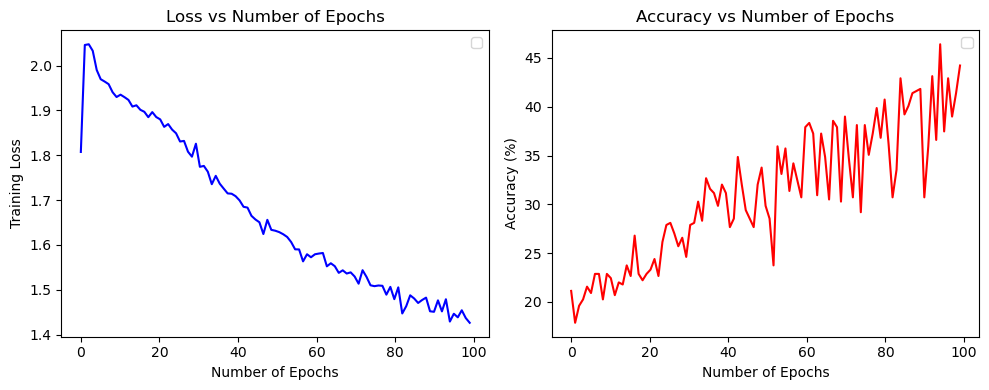

In [10]:
# trainingLoss1 = [(8/230) * x for x in trainingLoss]
# Plotting a Curve below
x = np.linspace(0, num_epochs-1, num_epochs-1)

# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # figsize=(width, height) in inches

# Plot on the first subplot (left)
ax1.plot(x, trainingLoss[1:], color='blue')
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Training Loss')
ax1.set_title('Loss vs Number of Epochs')
ax1.legend()

# Plot on the second subplot (right)
ax2.plot(x, whileTrainAcc[1:], color='red')
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy vs Number of Epochs')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()